In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
res = torch.load('/home2/aneesh.chavan/FinderNetReimplementation/src2/kitti_inference_scores.pt')

In [4]:
N, C, B, _ = res.shape

pos = res[:, 0, ...].reshape(N*B)
neg = res[:, 1, ...].reshape(N*B)

In [5]:
pos.shape, neg.shape

(torch.Size([6000]), torch.Size([6000]))

/tmp/ipykernel_5046/999808396.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


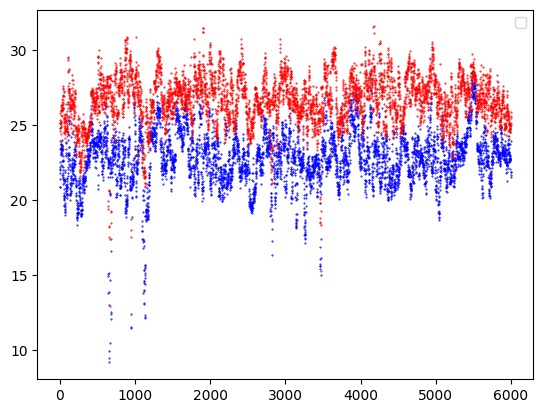

In [6]:
%matplotlib inline
fig = plt.figure()
plt.scatter([i for i in range(N*B)],  pos.cpu().detach(), c='b', s=0.2)
plt.scatter([i for i in range(N*B)],  neg.cpu().detach(), c='r', s=0.2)
plt.legend()

plt.show()

In [7]:
def plot_cumulative_histogram(data1, data2, bins=20):#, xlabel='Values', ylabel='Cumulative Frequency', title='Cumulative Histogram'):
    """
    Function to plot a cumulative histogram of given data.

    Parameters:
    - data: array-like, input data values
    - bins: int or sequence of scalars, optional (default=10)
            If an integer is given, `bins` + 1 bin edges are calculated and returned.
    - xlabel: str, optional (default='Values')
              Label for the x-axis
    - ylabel: str, optional (default='Cumulative Frequency')
              Label for the y-axis
    - title: str, optional (default='Cumulative Histogram')
             Title for the plot
    """
    fig, ax = plt.subplots()
    ax.hist(data1, bins=bins, cumulative=True, density=True, color='skyblue', alpha=0.5, edgecolor='black')
    ax.hist(data2, bins=bins, cumulative=True, density=True, color='red',     alpha=0.5, edgecolor='black')
    # ax.set_xlabel(xlabel)
    # ax.set_ylabel(ylabel)
    # ax.set_title(title)
    ax.grid(True)
    plt.show()

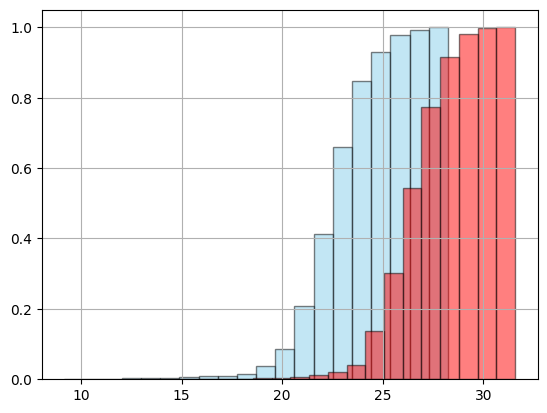

In [8]:
plot_cumulative_histogram(pos.detach().cpu().numpy(), neg.cpu().numpy())

In [9]:
epochs = 1000

def l(p, n, y):
    loss = np.count_nonzero(p.cpu().detach() > y) + np.count_nonzero(n.cpu().detach() < y)
    return loss

minY = np.inf
minL = np.inf
for y in np.arange(20,30, 10./5000):
    if l(pos, neg, y) < minL:
        minL = l(pos, neg, y)
        minY = y

print(minY, minL)
l(pos, neg, 25.)


24.56599999999747 1248


1333

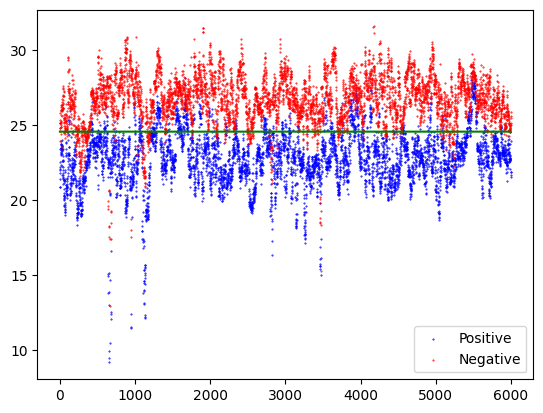

In [10]:
%matplotlib inline
fig = plt.figure()
plt.scatter([i for i in range(N*B)],  pos.cpu().detach(), c='b', s=0.2, label='Positive')
plt.scatter([i for i in range(N*B)],  neg.cpu().detach(), c='r', s=0.2, label='Negative')
plt.legend()
plt.plot([i for i in range(0, N*B)], [minY for i in range(0, N*B)], c='g')

plt.show()

In [11]:
def classify(pos, neg, Y):
    tn = float(np.count_nonzero(neg.detach().cpu().numpy() > Y))
    tp = float(np.count_nonzero(pos.detach().cpu().numpy() < Y))
    fn = float(np.count_nonzero(pos.detach().cpu().numpy() > Y))
    fp = float(np.count_nonzero(neg.detach().cpu().numpy() < Y))

    return tp,tn,fp,fn

def get_metrics(tp,tn,fp,fn):

    if tp + fp != 0:
        prec = tp/(tp+fp)
    else:
        prec = 0

    if tp + tn != 0:
        recall = tp/(tp+tn)
    else:
        recall = 0

    if (tp+tn+fn+fp) != 0:
        acc = (tp+tn)/(tp+tn+fn+fp)
    else:
        acc = 0

    if prec + recall != 0:
        f1 = 2 * (prec - recall)/(prec+recall)
    else:
        f1 = 0 

    return prec, recall, acc, f1


In [12]:
from icecream import ic

tp,tn,fp,fn = classify(pos, neg, minY)
prec, recall, acc, f1 = get_metrics(tp, tn, fp, fn)

ic(prec)
ic(recall)
ic(acc)
ic(f1);

ic| prec: 0.9215755855216465
ic| recall: 0.4830729166666667
ic| acc: 0.896
ic| f1: 0.624359287283378


In [13]:
precs = []
recalls = []

for y in np.arange(1,40, 40./20000):
    tp,tn,fp,fn = classify(pos, neg, y)
    prec, recall, acc, f1 = get_metrics(tp, tn, fp, fn)

    precs.append(prec)
    recalls.append(recall)

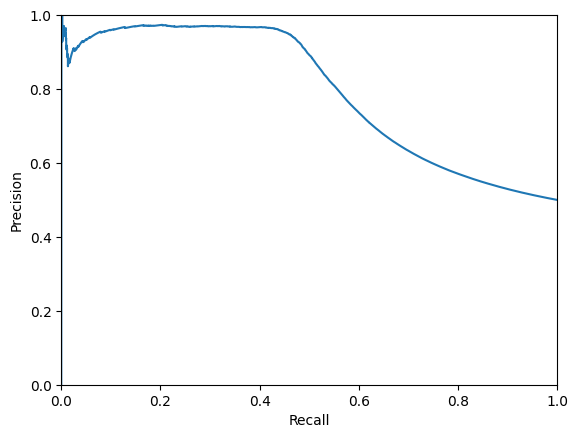

In [14]:
fig, ax = plt.subplots()
ax.plot(recalls, precs)
ax.set_xlim(0,1.)
ax.set_ylim(0,1.)

ax.set_ylabel("Precision")
ax.set_xlabel("Recall")

plt.show()